This notebook contains the preprocessing techniques applied to the data (text as well as images) and the models developed to predict whether a meme is general, sarcastic or non-sarcastic.

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os,sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

In [0]:


import pickle
import random
import shutil
import time

from google.colab import drive
from PIL import Image
from sklearn.model_selection import train_test_split

from tensorflow.keras import datasets, layers, models
from sklearn.metrics import classification_report

In [0]:
data_location=os.path.join('drive','My Drive')

In [175]:
! unzip -q "drive/My Drive/resized_data.zip" -d "resized_data"

replace resized_data/mrbri_3325.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


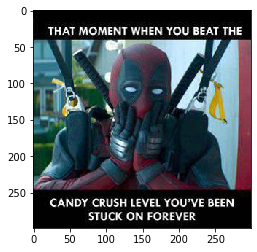

In [321]:
IMG_folder='resized_data'
img=mpimg.imread(os.path.join(IMG_folder,os.listdir(IMG_folder)[12]))
imgplot = plt.imshow(img)

In [177]:
memotion_file=pd.read_csv(os.path.join(data_location,'Memotion_data_corrected.csv'))
memotion_file.drop(columns=['Unnamed: 0'],inplace=True)
memotion_file.head()

,img_name,text,sarcasm_tag
0,10_year_2r94rv.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,general
1,10_year_10-year-challenge_1547788782.jpeg,The best of #10 YearChallenge! Completed in le...,general
2,10_year_10yearchallenge-5c75f8b946e0fb0001edc7...,Sam Thorne @Strippin ( Follow Follow Saw every...,not_sarcastic
3,10_year_10-year-challenge-sweet-dee-edition-40...,10 Year Challenge - Sweet Dee Edition,sarcastic
4,10_year_10-year-challenge-with-no-filter-47-hi...,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,sarcastic


Changing the img_name column values to point to the location of the image in the resized_data folder.

In [178]:
memotion_file['img_name']=memotion_file['img_name'].apply(lambda x: os.path.join('resized_data',x))
#Sanity checking if it was in the correct format
memotion_file.loc[0,'img_name']

'resized_data/10_year_2r94rv.jpg'

Checking if all images mentioned in the memotion_file are present in the folder containing resized images.

In [0]:

for img in memotion_file['img_name']:
  if img.split("/")[1] not in os.listdir('resized_data'):
    print(img)

Generating different files for diffrent categories of memes.

In [0]:

df_general=memotion_file[memotion_file['sarcasm_tag']=='general']
df_sarcastic=memotion_file[memotion_file['sarcasm_tag']=='sarcastic']
df_not_sarcastic=memotion_file[memotion_file['sarcasm_tag']=='not_sarcastic']

df_general.reset_index(drop=True,inplace=True)
df_sarcastic.reset_index(drop=True,inplace=True)
df_not_sarcastic.reset_index(drop=True,inplace=True)

Sanity checking the number of memes belonging to each category.

In [0]:
assert len(df_general)==3258
assert len(df_sarcastic)==1814
assert len(df_not_sarcastic)==1449

General meme


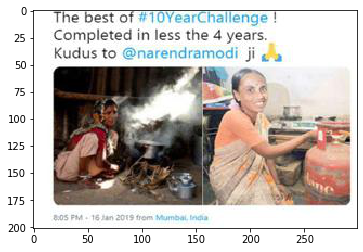

In [182]:
img=mpimg.imread(df_general.loc[1,'img_name'])
print('General meme')
imgplot = plt.imshow(img)


Reading the train, val and test files.

In [0]:
memotion_test=pd.read_csv(os.path.join(data_location,'Memotion_test_new.csv'))
memotion_train=pd.read_csv(os.path.join(data_location,'Memotion_train_new.csv'))
memotion_val=pd.read_csv(os.path.join(data_location,'Memotion_val_new.csv'))

In [184]:
memotion_train.loc[0,'text1']

"DONALD TRUMP DONALD T. DON T. DON'T. GLAD WE HAD THIS TALK. imgflip.com "

Sanity checking the number of memes in the train, val and test data.

In [0]:
assert len(memotion_test)==672
assert len(memotion_train)==3000
assert len(memotion_val)==675

In [0]:
memotion_test['img_name']=memotion_test['img_name'].apply(lambda x: os.path.join('resized_data',x.split('resized/')[1]))
memotion_train['img_name']=memotion_train['img_name'].apply(lambda x: os.path.join('resized_data',x.split('resized/')[1]))
memotion_val['img_name']=memotion_val['img_name'].apply(lambda x: os.path.join('resized_data',x.split('resized/')[1]))


In [187]:
memotion_test.head()

,img_name,text1,sarcasm_tag
0,resized_data/friends_56751362_398471770971562_...,Dogs when they get stung by a bee be like @mar...,general
1,resized_data/dr_evil_one-hundred-bilililion-do...,ONE HUNDRED BILLLILION DOLLARS imgflip.com dr ...,general
2,resized_data/third_2r0m5p.jpg,SEGA: WE ARE GOING TO MAKE A SONIC GAME THAT D...,general
3,resized_data/titanic_republicans-climate-titan...,If we're sinking why are we hundreds of feet u...,general
4,resized_data/chandler_49933872_295824287789465...,IB Students AP Students What do you got here? ...,general


In [0]:
memotion_test_f = memotion_test.sample(frac=1).reset_index(drop=True)
memotion_train_f = memotion_train.sample(frac=1).reset_index(drop=True)
memotion_val_f = memotion_val.sample(frac=1).reset_index(drop=True)

In [0]:
memotion_test_f.to_csv('Memotion_test_data.csv')
memotion_train_f.to_csv('Memotion_train_data.csv')
memotion_val_f.to_csv('Memotion_validation_data.csv')

Converting string labels to integers

Class 0: General Memes
Class 1: Sarcastic Memes
Class 2: Non-Sarcastic Memes

In [0]:
memotion_test_f['sarcasm_tag']=memotion_test_f['sarcasm_tag'].apply(lambda x: 0 if x=='general' else (1 if x=='sarcasm' else 2))
memotion_train_f['sarcasm_tag']=memotion_train_f['sarcasm_tag'].apply(lambda x: 0 if x=='general' else (1 if x=='sarcasm' else 2))
memotion_val_f['sarcasm_tag']=memotion_val_f['sarcasm_tag'].apply(lambda x: 0 if x=='general' else (1 if x=='sarcasm' else 2))


In [191]:
memotion_test_f['sarcasm_tag'].value_counts()

2    224
1    224
0    224
Name: sarcasm_tag, dtype: int64

In [192]:
memotion_train_f['sarcasm_tag'].value_counts()

1    1000
2    1000
0    1000
Name: sarcasm_tag, dtype: int64

In [193]:
memotion_val_f['sarcasm_tag'].value_counts()

2    225
1    225
0    225
Name: sarcasm_tag, dtype: int64

As is evident from the output of the last 3 cells, we have prepared a balanced train, val and test dataset by performing undersampling. The presence of class balance in the train set ensures that we can use loss and accuracy as our evaluation metrics.

In [0]:
memotion_train_f['sarcasm_tag']=memotion_train_f['sarcasm_tag'].astype('float32')
memotion_val_f['sarcasm_tag']=memotion_val_f['sarcasm_tag'].astype('float32')
memotion_test_f['sarcasm_tag']=memotion_test_f['sarcasm_tag'].astype('float32')

## Preprocessing text

The following preprocessing techniques were applied on meme text using regex:
1. Removal of URLs present in the text [The text contained URLs other than the .com,.in and .net ones also,which was taken care of by analyzing our data]
2. Removing tags (@ some_person)
3. Removing the word via because it leaks the info that the meme was taken from a meme website.
3. Converting the text to lowercase
4. Removing punctuation marks

In [0]:
def preprocess_text(df):
  df['text1']=df['text1'].str.lower()
  df['text1'].replace(to_replace=r'\w+.com[\w\W]*',value=' ',regex=True,inplace=True)
  df['text1'].replace(to_replace=r'\w+.net ',value=' ',regex=True,inplace=True)
  df['text1'].replace(to_replace=r'\w+.co[\w\W]*',value=' ',regex=True, inplace=True)
  df['text1'].replace(to_replace=r'\w*https://\w+',value='',regex=True,inplace=True)
  df['text1'].replace(to_replace=r'\w*http://\w+',value=' ',regex=True, inplace=True)
  df['text1'].replace(to_replace=r'\w+.mobi ',value=' ',regex=True, inplace=True)
  df['text1'].replace(to_replace=r'\w+.es ',value=' ',regex=True, inplace=True)
  df['text1'].replace(to_replace=r'\w*www\w+',value=' ',regex=True,inplace=True)
  df['text1'].replace(to_replace=r'\w+.in ',value=' ',regex=True,inplace=True)
  df['text1'].replace(to_replace=r'via',value=' ',regex=True,inplace=True)
  df['text1'].replace(to_replace=r'\w*@\w+',value=' ',regex=True,inplace=True)
  df['text1'].replace(to_replace=r'\w+.updates ',value=' ',regex=True,inplace=True)
  df['text1'].replace(to_replace=r'\w+.strangely ',value=' ',regex=True,inplace=True)
  df['text1'].replace(to_replace=r'\w+.eu',value=' ',regex=True,inplace=True)
  df['text1'].replace(to_replace=r'\w+.lower',value=' ',regex=True,inplace=True)
  df['text1'].replace(to_replace=r'\w+.org',value=' ',regex=True,inplace=True)
  df['text1'].replace(to_replace=r'\w+.com/\w+',value=' ',regex=True,inplace=True)
  df['text1'].replace(to_replace=r'memecenter',value=' ',regex=True,inplace=True)
  df['text1'].replace(to_replace=r'\w+.xyz',value=' ',regex=True,inplace=True)
  df['text1'].replace(to_replace=r'\w+.book',value=' ',regex=True,inplace=True)
  df['text1'].replace(to_replace='[^\w\s]',value='',regex=True,inplace=True)
  return df

In [0]:
mem_train_pre=preprocess_text(memotion_train_f)
mem_test_pre=preprocess_text(memotion_test_f)
mem_val_pre=preprocess_text(memotion_val_f)

In [0]:
mem_train_pre.to_csv('Memotion_train_preprocessed.csv')
mem_test_pre.to_csv('Memotion_test_preprocessed.csv')
mem_val_pre.to_csv('Memotion_val_preprocessed.csv')

Sanity checking the number of memes in the train, val and test datasets and the class balance.

In [198]:
memotion_test_f['sarcasm_tag'].value_counts()

2.0    224
0.0    224
1.0    224
Name: sarcasm_tag, dtype: int64

In [199]:
memotion_val_f['sarcasm_tag'].value_counts()

1.0    225
2.0    225
0.0    225
Name: sarcasm_tag, dtype: int64

In [200]:
memotion_train_f['sarcasm_tag'].value_counts()

0.0    1000
1.0    1000
2.0    1000
Name: sarcasm_tag, dtype: int64

## Modeling the data

Baseline models:
1. Image only
2. Text only - other notebook

## Image only

Creating train, val and test directories to copy images belonging to these sets from the resized_data folder.

In [0]:
base_dir="Memotion_data"
os.mkdir(base_dir)

mem_train_dir = os.path.join(base_dir,'Train')
mem_val_dir = os.path.join(base_dir,'Val')
mem_test_dir = os.path.join(base_dir,'Test')

os.mkdir(mem_train_dir)
os.mkdir(mem_val_dir)
os.mkdir(mem_test_dir)

general_train_dir = os.path.join(mem_train_dir,'General')
general_val_dir = os.path.join(mem_val_dir,'General')
general_test_dir = os.path.join(mem_test_dir,'General')
os.mkdir(general_train_dir)
os.mkdir(general_val_dir)
os.mkdir(general_test_dir)

sarcastic_train_dir = os.path.join(mem_train_dir,'Sarcastic')
sarcastic_val_dir = os.path.join(mem_val_dir,'Sarcastic')
sarcastic_test_dir = os.path.join(mem_test_dir,'Sarcastic')
os.mkdir(sarcastic_train_dir)
os.mkdir(sarcastic_val_dir)
os.mkdir(sarcastic_test_dir)

non_sarcastic_train_dir = os.path.join(mem_train_dir,'Non-Sarcastic')
non_sarcastic_val_dir = os.path.join(mem_val_dir,'Non-Sarcastic')
non_sarcastic_test_dir = os.path.join(mem_test_dir,'Non-Sarcastic')
os.mkdir(non_sarcastic_train_dir)
os.mkdir(non_sarcastic_val_dir)
os.mkdir(non_sarcastic_test_dir)




In [0]:
fnames_ge_tr = memotion_train_f.loc[memotion_train_f['sarcasm_tag']==0,'img_name']
fnames_ge_val = memotion_val_f.loc[memotion_val_f['sarcasm_tag']==0,'img_name']
fnames_ge_te = memotion_test_f.loc[memotion_test_f['sarcasm_tag']==0,'img_name']

fnames_sa_tr = memotion_train_f.loc[memotion_train_f['sarcasm_tag']==1,'img_name']
fnames_sa_val = memotion_val_f.loc[memotion_val_f['sarcasm_tag']==1,'img_name']
fnames_sa_te = memotion_test_f.loc[memotion_test_f['sarcasm_tag']==1,'img_name']

fnames_ns_tr = memotion_train_f.loc[memotion_train_f['sarcasm_tag']==2,'img_name']
fnames_ns_val = memotion_val_f.loc[memotion_val_f['sarcasm_tag']==2,'img_name']
fnames_ns_te = memotion_test_f.loc[memotion_test_f['sarcasm_tag']==2,'img_name']

Sanity checking the number of memes in each category.

In [0]:
#Verifying training data
assert len(fnames_ge_tr)==1000
assert len(fnames_sa_tr)==1000
assert len(fnames_ns_tr)==1000

#Verifying validation data
assert len(fnames_ge_val)==225
assert len(fnames_sa_val)==225
assert len(fnames_ns_val)==225

#Verifying testing data
assert len(fnames_ge_te)==224
assert len(fnames_sa_te)==224
assert len(fnames_ns_te)==224

In [0]:
# Copying training images
for i in fnames_ge_tr:
  dst=os.path.join(general_train_dir,i.split('/')[1])
  shutil.copyfile(i,dst)

for i in fnames_sa_tr:
  dst=os.path.join(sarcastic_train_dir,i.split('/')[1])
  shutil.copyfile(i,dst)

for i in fnames_ns_tr:
  dst=os.path.join(non_sarcastic_train_dir,i.split('/')[1])
  shutil.copyfile(i,dst)

In [0]:
# Copying validation images
for i in fnames_ge_val:
  dst=os.path.join(general_val_dir,i.split('/')[1])
  shutil.copyfile(i,dst)

for i in fnames_sa_val:
  dst=os.path.join(sarcastic_val_dir,i.split('/')[1])
  shutil.copyfile(i,dst)

for i in fnames_ns_val:
  dst=os.path.join(non_sarcastic_val_dir,i.split('/')[1])
  shutil.copyfile(i,dst)

In [0]:
# Copying testing images
for i in fnames_ge_te:
  dst=os.path.join(general_test_dir,i.split('/')[1])
  shutil.copyfile(i,dst)

for i in fnames_sa_te:
  dst=os.path.join(sarcastic_test_dir,i.split('/')[1])
  shutil.copyfile(i,dst)

for i in fnames_ns_te:
  dst=os.path.join(non_sarcastic_test_dir,i.split('/')[1])
  shutil.copyfile(i,dst)

Verifying that train, test and val directories contain the ocrrect number of images in each category of memes (General, Sarcastic, Non-Sarcastic)

In [0]:
#Verifying General category images
assert len(os.listdir(general_train_dir))==1000
assert len(os.listdir(general_val_dir))==225
assert len(os.listdir(general_test_dir))==224

#Verifying Sarcastic Category images
assert len(os.listdir(sarcastic_train_dir))==1000
assert len(os.listdir(sarcastic_val_dir))==225
assert len(os.listdir(sarcastic_test_dir))==224

#Verifying Non Sarcastic Category images
assert len(os.listdir(non_sarcastic_train_dir))==1000
assert len(os.listdir(non_sarcastic_val_dir))==225
assert len(os.listdir(non_sarcastic_test_dir))==224

In [0]:
label_names = sorted(item for item in os.listdir(mem_train_dir))
print(label_names)

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(mem_train_dir,target_size=(299,299),batch_size=32,class_mode='sparse')
val_generator = val_datagen.flow_from_directory(mem_val_dir,target_size=(299,299), batch_size=32,class_mode='sparse')
test_generator = test_datagen.flow_from_directory(mem_test_dir, target_size=(299,299), batch_size=32,class_mode='sparse',shuffle=False)
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break
    


Found 3000 images belonging to 3 classes.
Found 675 images belonging to 3 classes.
Found 672 images belonging to 3 classes.
data batch shape: (32, 299, 299, 3)
labels batch shape: (32,)


In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(299, 299, 3)))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [0]:
#Plots showing training and validation loss and accuracy as a function of epochs
def plot(history):
  
  # The history object contains results on the training and test
  # sets for each epoch
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()


In [0]:
history = model.fit_generator(
      train_generator,
      epochs=5,
      validation_data=val_generator)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 94 steps, validate for 22 steps
Epoch 1/5
94/94 [==============================] - 12s 127ms/step - loss: 1.5713 - accuracy: 0.3250 - val_loss: 1.0986 - val_accuracy: 0.3407
Epoch 2/5
94/94 [==============================] - 12s 123ms/step - loss: 1.0959 - accuracy: 0.3500 - val_loss: 1.1025 - val_accuracy: 0.3393
Epoch 3/5
94/94 [==============================] - 12s 125ms/step - loss: 1.0499 - accuracy: 0.4783 - val_loss: 1.1225 - val_accuracy: 0.3467
Epoch 4/5
94/94 [==============================] - 12s 125ms/step - loss: 0.8320 - accuracy: 0.6407 - val_loss: 1.3281 - val_accuracy: 0.3363
Epoch 5/5
94/94 [==============================] - 12s 123ms/step - loss: 0.5411 - accuracy: 0.7837 - val_loss: 1.6195 - val_accuracy: 0.3274


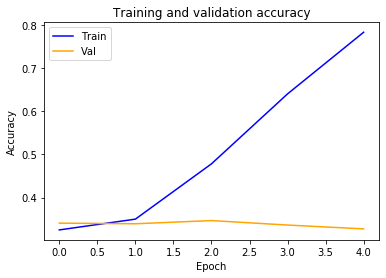

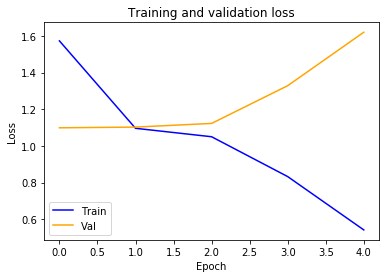

In [0]:
plot(history)

In [0]:
predictions = model.predict(test_generator)

In [0]:
preds= [np.argmax(y) for y in list(predictions)]

In [0]:

print(classification_report(test_generator.classes,preds))

              precision    recall  f1-score   support

           0       0.36      0.33      0.35       224
           1       0.35      0.38      0.36       224
           2       0.33      0.32      0.33       224

    accuracy                           0.35       672
   macro avg       0.35      0.35      0.35       672
weighted avg       0.35      0.35      0.35       672



As seen, thee accuracy on the test set is 35% which is better than chance(33%).

In [0]:
y_true=test_generator.classes

In [0]:
correct_preds=[]
incorrect_preds=[]
for i in range(len(preds)):
  if preds[i]==y_true[i]:
    correct_preds.append(i)
  else:
    incorrect_preds.append(i)

In [0]:
files=test_generator.filenames

In [0]:
label_dict={0:'General',1:'Sarcastic',2:'Non-Sarcastic'}

2 correct predictions

Prediction: General
Actual: General


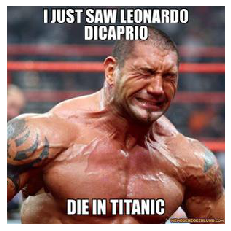

In [0]:
#Correct Prediction
i=correct_preds[68]

img=plt.imread(os.path.join(mem_test_dir,files[i]))

print("Prediction:", label_dict[preds[i]])
print("Actual:", label_dict[y_true[i]])
plt.axis('off')
_=plt.imshow(img)

Prediction: Sarcastic
Actual: Sarcastic


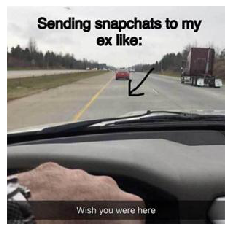

In [0]:
#Correct Prediction
i=correct_preds[104]

img=plt.imread(os.path.join(mem_test_dir,files[i]))

print("Prediction:", label_dict[preds[i]])
print("Actual:", label_dict[y_true[i]])
plt.axis('off')
_=plt.imshow(img)

2 incorrect predictions

Prediction: Sarcastic
Actual: General


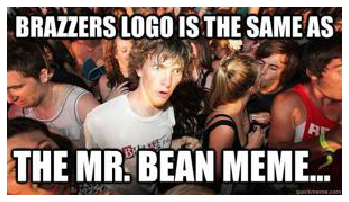

In [0]:
#Incorrect Prediction
i=incorrect_preds[5]

img=plt.imread(os.path.join(mem_test_dir,files[i]))

print("Prediction:", label_dict[preds[i]])
print("Actual:", label_dict[y_true[i]])
plt.axis('off')
_=plt.imshow(img)

Prediction: Non-Sarcastic
Actual: Sarcastic


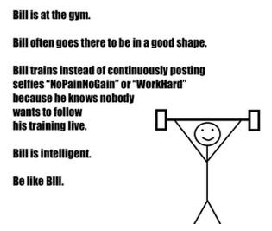

In [0]:
#Incorrect Prediction
i=incorrect_preds[163]

img=plt.imread(os.path.join(mem_test_dir,files[i]))
print("Prediction:", label_dict[preds[i]])
print("Actual:", label_dict[y_true[i]])
plt.axis('off')
_=plt.imshow(img)

Next, we try to validation accuracy by using augmentation

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./225)

train_generator = train_datagen.flow_from_directory(mem_train_dir,target_size=(299,299),batch_size=32,class_mode='sparse')
val_generator = val_datagen.flow_from_directory(mem_val_dir,target_size=(299,299), batch_size=32,class_mode='sparse')
test_generator = test_datagen.flow_from_directory(mem_test_dir,target_size=(299,299),batch_size=32, class_mode='sparse',shuffle=False)
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

Found 3000 images belonging to 3 classes.
Found 675 images belonging to 3 classes.
Found 672 images belonging to 3 classes.
data batch shape: (32, 299, 299, 3)
labels batch shape: (32,)


In [0]:
model1 = models.Sequential()
model1.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(299, 299, 3)))
model1.add(layers.MaxPooling2D())
model1.add(layers.Conv2D(32, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D())
model1.add(layers.Flatten())
model1.add(layers.Dense(3, activation='softmax'))

model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [0]:
history1 = model1.fit_generator(
      train_generator,
      epochs=5,
      validation_data=val_generator)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 94 steps, validate for 22 steps
Epoch 1/5
94/94 [==============================] - 57s 610ms/step - loss: 1.4871 - accuracy: 0.3270 - val_loss: 1.0987 - val_accuracy: 0.3393
Epoch 2/5
94/94 [==============================] - 57s 603ms/step - loss: 1.0906 - accuracy: 0.3727 - val_loss: 1.1028 - val_accuracy: 0.3244
Epoch 3/5
94/94 [==============================] - 56s 598ms/step - loss: 0.9851 - accuracy: 0.5387 - val_loss: 1.1853 - val_accuracy: 0.3378
Epoch 4/5
94/94 [==============================] - 56s 598ms/step - loss: 0.6524 - accuracy: 0.7317 - val_loss: 1.3643 - val_accuracy: 0.3393
Epoch 5/5
94/94 [==============================] - 56s 597ms/step - loss: 0.3188 - accuracy: 0.8977 - val_loss: 1.8279 - val_accuracy: 0.3407


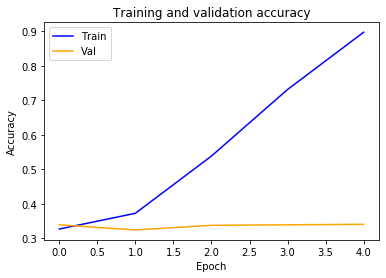

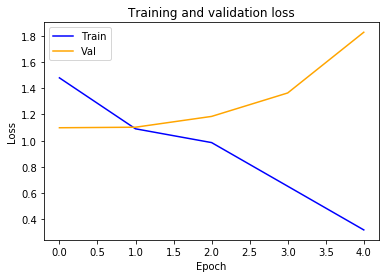

In [0]:
plot(history1)

In [0]:
predictions = model.predict(test_generator)

In [0]:
preds= [np.argmax(y) for y in list(predictions)]

In [0]:
print(classification_report(test_generator.classes,preds))

              precision    recall  f1-score   support

           0       0.36      0.34      0.35       224
           1       0.35      0.38      0.37       224
           2       0.33      0.32      0.33       224

    accuracy                           0.35       672
   macro avg       0.35      0.35      0.35       672
weighted avg       0.35      0.35      0.35       672



Surprisingly, this model with data augmentation achieves a better training accuracy and a lesser validation loss as compared to the previous model. However, it's performance on the test set is almost equal(accuracy: 35%)with only a slightly better recall and f-1 score for the 'sarcastic' class. Since we aim to detect sarcasm in memes, we will be considering the model with data augmentation as our best model.

We tried using various augmentation techniques including rotation, height_shift and width shift and also experimented with the deep learning network, but sadly couldn't achieve a better accuracy.

In [0]:
y_true=test_generator.classes

In [0]:
correct_preds=[]
incorrect_preds=[]
for i in range(len(preds)):
  if preds[i]==y_true[i]:
    correct_preds.append(i)
  else:
    incorrect_preds.append(i)

In [0]:
files=test_generator.filenames

2 correct predictions

Prediction: General
Actual: General


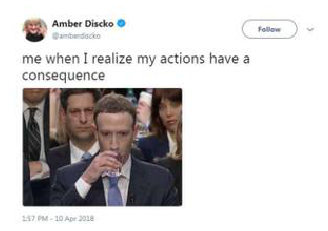

In [0]:
#Correct Prediction
i=correct_preds[74]

img=plt.imread(os.path.join(mem_test_dir,files[i]))

print("Prediction:", label_dict[preds[i]])
print("Actual:", label_dict[y_true[i]])
plt.axis('off')
_=plt.imshow(img)

Prediction: General
Actual: General


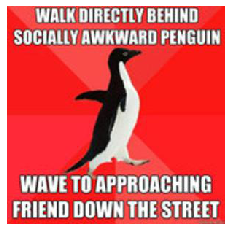

In [0]:
#Correct Prediction
i=correct_preds[46]

img=plt.imread(os.path.join(mem_test_dir,files[i]))

print("Prediction:", label_dict[preds[i]])
print("Actual:", label_dict[y_true[i]])
plt.axis('off')
_=plt.imshow(img)

2 incorrect predictions

Prediction: Sarcastic
Actual: General


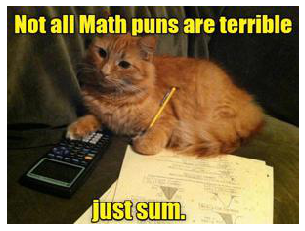

In [0]:
#Incorrect Prediction
i=incorrect_preds[25]

img=plt.imread(os.path.join(mem_test_dir,files[i]))

print("Prediction:", label_dict[preds[i]])
print("Actual:", label_dict[y_true[i]])
plt.axis('off')
_=plt.imshow(img)

Prediction: General
Actual: Sarcastic


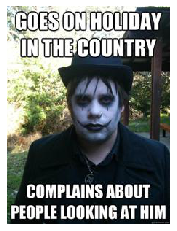

In [0]:
#Incorrect Prediction
i=incorrect_preds[178]

img=plt.imread(os.path.join(mem_test_dir,files[i]))

print("Prediction:", label_dict[preds[i]])
print("Actual:", label_dict[y_true[i]])
plt.axis('off')
_=plt.imshow(img)

## Image + Text

Activation extraction

In [0]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [0]:

def image_to_activations(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (299, 299))
  activations = tf.keras.applications.inception_v3.preprocess_input(img)
  return activations, image_path

In [0]:
train_path_set = set(memotion_train_f['img_name'])
test_path_set = set(memotion_test_f['img_name'])
valid_path_set = set(memotion_val_f['img_name'])

In [205]:
image_path_set = train_path_set | test_path_set | valid_path_set

print("Images to preprocess", len(image_path_set))
assert len(image_path_set)==4347
print("This make take a few minutes")

Images to preprocess 4347
This make take a few minutes


Extracting activation from images and storing to disk

In [0]:
activation_dataset = tf.data.Dataset.from_tensor_slices(list(image_path_set))
activation_dataset = activation_dataset.map(
  image_to_activations, 
  num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)

for img_batch, path_batch in activation_dataset:
  batch_features = image_features_extract_model(img_batch)
  for bf, p in zip(batch_features, path_batch):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())  

List of text, labels and images for training, validation and test data

In [0]:
memotion_train_f['text1']=memotion_train_f['text1'].astype(str)

text_train = list(memotion_train_f['text1'])
label_train = list(memotion_train_f['sarcasm_tag'])
images_train = list(memotion_train_f['img_name'])

In [0]:
memotion_val_f['text1']=memotion_val_f['text1'].astype(str)

text_val = list(memotion_val_f['text1']) 
label_val = list(memotion_val_f['sarcasm_tag'])
images_val = list(memotion_val_f['img_name'])

In [0]:
memotion_test_f['text1'] = memotion_test_f['text1'].astype(str)

text_test = list(memotion_test_f['text1'])
label_test = list(memotion_test_f['sarcasm_tag'])
images_test = list(memotion_test_f['img_name'])

Create and fit a tokenizer

In [0]:
VOCAB_SIZE = 3000

In [211]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(text_train)

print("Word index", len(tokenizer.word_index))

Word index 6195


In [0]:
sequences_train = tokenizer.texts_to_sequences(text_train)
sequences_val = tokenizer.texts_to_sequences(text_val)
sequences_test = tokenizer.texts_to_sequences(text_test)

In [0]:
length_sequences = [len(i) for i in sequences_train]

In [214]:
from statistics import mode
print(np.mean(length_sequences))
print(np.median(length_sequences))

10.396333333333333
9.0


In [215]:
len(length_sequences)

3000

In [0]:
MAX_SEQ_LEN = 20

In [0]:
padded_train = tf.keras.preprocessing.sequence.pad_sequences(sequences_train,maxlen=MAX_SEQ_LEN)
padded_val = tf.keras.preprocessing.sequence.pad_sequences(sequences_val,maxlen=MAX_SEQ_LEN)
padded_test = tf.keras.preprocessing.sequence.pad_sequences(sequences_test,maxlen=MAX_SEQ_LEN)

Converting vectorized text back to string

In [0]:
train_try = tokenizer.sequences_to_texts(padded_train)
val_try = tokenizer.sequences_to_texts(padded_val)
test_try = tokenizer.sequences_to_texts(padded_test)

In [219]:
train_try[:10]

['is this a cat or a snail',
 'if i wanted your opinion id untie you and take my dick out of your mouth',
 'reasons to livs happy pepe',
 'just hanging with ur buds on',
 'dafuq are you looking at',
 'p with a random thought step 2 put it next to a minion doing something totally unrelated to the thought',
 'why do gorillas always have a frown 10 million years they will be niggers',
 'they see me rulin they hatin',
 'season 1 only a fool would meet the dothraki season 7 the dirty an open field',
 'what did this squirrel know about hillary clinton']

In [220]:
val_try[:10]

['the only you should call a woman is beautiful love being called beautiful',
 'that look you get when you watch democrats bitch and about the',
 'happy dont show off now we know its our birthday',
 'when youre at your job and your gets mad',
 'we are all mature when random people start talking to the until somebody brings out some meet',
 'never thought id die fighting side by side with an what about side by side with a friend',
 'when you call football soccer',
 'al will the of nuclear yet it a space',
 'da is cute now i break you',
 'jim carrey carrey accidentally said happy day to my person instead of writing a on social media']

In [221]:
test_try[:10]

['god jews god jesus jews jesus god hitler modern problems modern',
 'i may play the fool at but im more than just a pretty with an ass that wont quit',
 '',
 'why cant they draw like the animated from the 90s i mean look at that',
 'man door hes sexist man doesnt hold door hes an asshole',
 'ig americas',
 'this is iceberg it titanic this is zuckerberg it life of',
 'htmlhead',
 'a great your mind but you cant find the to make it im limited by the technology of my time',
 'u cant see know what i mean']

Creating tf.data for train,validation and split

In [0]:
# Using batch size of 64 so that the model trains slower but better.
BATCH_SIZE = 64
BUFFER_SIZE = 1000

In [0]:
def load_np(img_path, question, answer):
  activations = np.load(img_path.decode('utf-8')+'.npy')
  return activations, question, answer, img_path

In [0]:
def create_dataset(images, sequences, answers):
  dataset = tf.data.Dataset.from_tensor_slices((images, 
                                                sequences, 
                                                answers))

  dataset = dataset.map(lambda x, y, z: tf.numpy_function(
      load_np, [x, y, z], [tf.float32, tf.int32, tf.float32, tf.string]),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  
  dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

In [0]:
train_ds = create_dataset(images_train, padded_train, label_train)
val_ds = create_dataset(images_val, padded_val, label_val)
test_ds = create_dataset(images_test, padded_test, label_test )

In [226]:
print(type(padded_train[0]))
print(type(images_train[0]))
print(type(label_train[0]))

<class 'numpy.ndarray'>
<class 'str'>
<class 'float'>


In [227]:
my_iterator = iter(train_ds)
activations_batch, questions_batch, answers_batch, paths_batch = next(my_iterator)

print(activations_batch.shape, 
       questions_batch.shape, 
       answers_batch.shape, 
       paths_batch.shape)


(64, 8, 8, 2048) (64, 20) (64,) (64,)


In [0]:
from tensorflow.keras.layers import Dense, Embedding, Flatten, Input, LSTM, Dropout
from tensorflow.keras.models import Model, Sequential

In [0]:
image_input = Input(shape=(8, 8, 2048)) 
vision_model = Sequential()

vision_model.add(tf.keras.layers.GlobalAveragePooling2D())

encoded_image = vision_model(image_input) 

question_input = Input(shape=(20,), dtype='int32')
embedded_question = Embedding(input_dim=5000, output_dim=128, input_length=20)(question_input)
dropout_layer = Dropout(0.5)(embedded_question)
encoded_question = LSTM(128)(dropout_layer)

merged = tf.keras.layers.concatenate([encoded_image, encoded_question])

dense = Dense(128, activation='relu')(merged)

output = Dense(3, activation='softmax')(dense)

model = Model(inputs=[image_input, question_input], outputs=output)

In [91]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 20, 128)      640000      input_7[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 8, 8, 2048)] 0                                            
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 20, 128)      0           embedding_2[0][0]                
____________________________________________________________________________________________

In [0]:

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Plotting the model

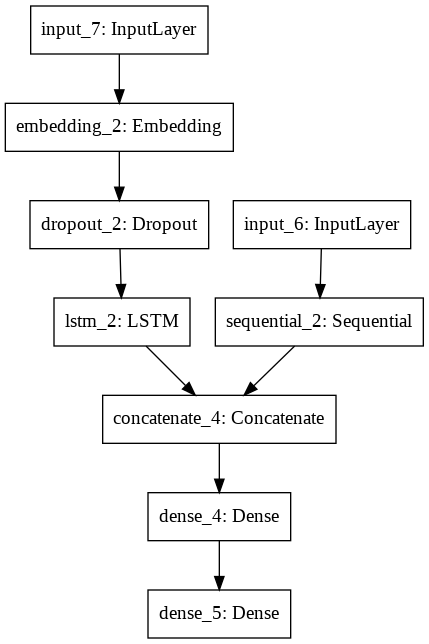

In [93]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model1.png')

In [0]:
activations_batch, questions_batch, answers_batch, paths_batch = next(iter(train_ds))

Metrics

In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.SparseCategoricalCrossentropy(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

Evaluate on the test set

In [0]:
def evaluate(max_steps=None):
  steps = 0
  for activation_batch, question_batch, answer_batch, path_batch in val_ds:
    if max_steps != None and steps == max_steps:
      break
    predictions = model.predict(x=[activation_batch, question_batch])
    steps += 1 
    
    val_loss(answer_batch, predictions)
    val_accuracy(answer_batch, predictions)

In [97]:

train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []

epochs = 10 

for epoch in range(epochs):

  start = time.time()

  for activation_batch, question_batch, answer_batch, path_batch in train_ds:
    result = model.train_on_batch(x=[activation_batch, question_batch], y=answer_batch)

    train_loss(result[0])
    train_accuracy(result[1])

  evaluate(max_steps=100)

  template = 'Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Val Loss {:.2f}, Val Accuracy {:.2f}, Time: {:.1f} secs'
  print(template.format(epoch,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        val_loss.result(),
                        val_accuracy.result() * 100,
                        time.time() - start))
  
  train_loss_history.append(train_loss.result())
  train_acc_history.append(train_accuracy.result() * 100)
  val_loss_history.append(val_loss.result())
  val_acc_history.append(val_accuracy.result() * 100)

  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()
  

Epoch 0, Loss: 1.16, Accuracy: 34.02, Val Loss 1.11, Val Accuracy 33.63, Time: 6.3 secs
Epoch 1, Loss: 1.10, Accuracy: 36.78, Val Loss 1.13, Val Accuracy 35.85, Time: 4.3 secs
Epoch 2, Loss: 1.09, Accuracy: 39.50, Val Loss 1.11, Val Accuracy 33.48, Time: 4.4 secs
Epoch 3, Loss: 1.02, Accuracy: 46.59, Val Loss 1.18, Val Accuracy 34.67, Time: 4.5 secs
Epoch 4, Loss: 0.90, Accuracy: 55.54, Val Loss 1.28, Val Accuracy 29.93, Time: 4.5 secs
Epoch 5, Loss: 0.81, Accuracy: 59.80, Val Loss 1.44, Val Accuracy 33.19, Time: 4.4 secs
Epoch 6, Loss: 0.69, Accuracy: 68.47, Val Loss 1.50, Val Accuracy 31.41, Time: 4.7 secs
Epoch 7, Loss: 0.61, Accuracy: 74.05, Val Loss 1.64, Val Accuracy 30.07, Time: 4.4 secs
Epoch 8, Loss: 0.50, Accuracy: 78.79, Val Loss 2.00, Val Accuracy 32.15, Time: 4.3 secs
Epoch 9, Loss: 0.43, Accuracy: 82.44, Val Loss 2.15, Val Accuracy 32.44, Time: 4.3 secs


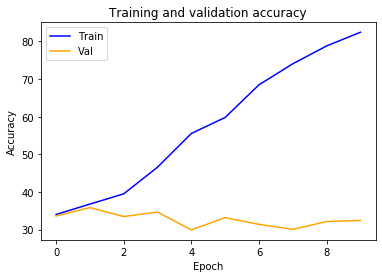

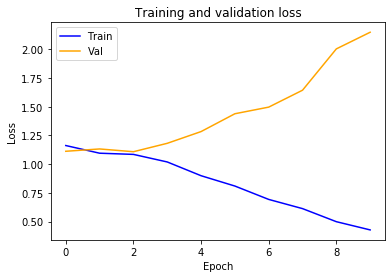

In [98]:
epochs = range(len(val_acc_history))

plt.title('Training and validation accuracy')
plt.plot(epochs, train_acc_history, color='blue', label='Train')
plt.plot(epochs, val_acc_history, color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

_ = plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, train_loss_history, color='blue', label='Train')
plt.plot(epochs, val_loss_history, color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [0]:

predictions_final=[]
def evaluate_test(max_steps=None):
  steps = 0
  for activation_batch, question_batch, answer_batch, path_batch in test_ds:
    predictions = model.predict(x=[activation_batch, question_batch])
    #print(type(predictions))
    predictions_final.append(predictions)


In [0]:
evaluate_test()

In [0]:
preds=[np.argmax(y) for x in predictions_final for y in x]

In [102]:
print(classification_report(label_test,preds))

              precision    recall  f1-score   support

         0.0       0.38      0.36      0.37       224
         1.0       0.35      0.32      0.33       224
         2.0       0.35      0.40      0.38       224

    accuracy                           0.36       672
   macro avg       0.36      0.36      0.36       672
weighted avg       0.36      0.36      0.36       672



As seen in the classification report, the image + text model using Inception V3 activations and a keras embedding layer has an accuracy of 36% which is better than chance(33%) and our best model using only images(35%). 

This model is currently the best model to detect sarcasm based on meme images and meme text. We tried different sequence lengths, vocab_size and neural network architectures. But we couldn't achieve an accuracy beyond 36%.

Predictions

In [0]:
correct_preds=[]
incorrect_preds=[]
for i in range(len(label_test)):
  if label_test[i]==preds[i]:
    correct_preds.append(i)
  else:
    incorrect_preds.append(i)

2 Correct Predictions

Meme text: never let the bullshit stress you the success club 
Prediction: General
Actual: General


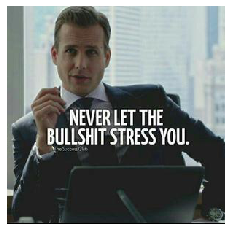

In [114]:
i=correct_preds[8]
img=plt.imread(images_test[i])
print('Meme text:',text_test[i])
print("Prediction:", label_dict[int(preds[i])])
print("Actual:", label_dict[int(label_test[i])])
plt.axis('off')
_=plt.imshow(img)

Meme text: donald trump stole my hair  
Prediction: Sarcastic
Actual: Sarcastic


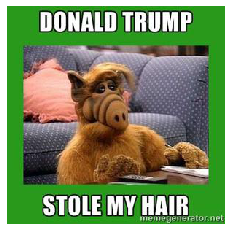

In [120]:
i=correct_preds[14]
img=plt.imread(images_test[i])
print('Meme text:',text_test[i])
print("Prediction:", label_dict[int(preds[i])])
print("Actual:", label_dict[int(label_test[i])])
plt.axis('off')
_=plt.imshow(img)

2 Incorrect predictions

Meme text:   jungkook all the possible artists  
Prediction: Non-Sarcastic
Actual: Sarcastic


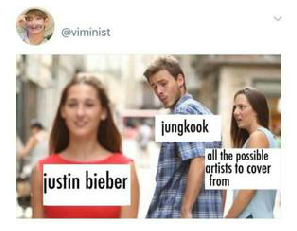

In [134]:
i=incorrect_preds[13]
img=plt.imread(images_test[i])
print('Meme text:',text_test[i])
print("Prediction:", label_dict[int(preds[i])])
print("Actual:", label_dict[int(label_test[i])])
plt.axis('off')
_=plt.imshow(img)

Meme text: hands up if you love fridays 
Prediction: Sarcastic
Actual: Non-Sarcastic


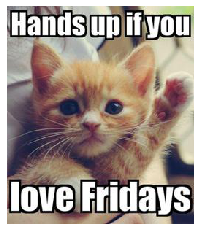

In [170]:
i=incorrect_preds[49]
img=plt.imread(images_test[i])
print('Meme text:',text_test[i])
print("Prediction:", label_dict[int(preds[i])])
print("Actual:", label_dict[int(label_test[i])])
plt.axis('off')
_=plt.imshow(img)

Next, we try an image+text model using imagenet activations and glove embedding.

In [228]:

GLOVE_DIR=os.path.join('drive','My Drive')

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.42B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


Found 1917494 word vectors.


In [0]:
EMBEDDING_DIM = 300 # how big is each word vector
word_index= tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=20,
                            trainable=False)

In [0]:
#GLOVE with dropout

image_input = Input(shape=(8, 8, 2048)) 
vision_model = Sequential()

vision_model.add(tf.keras.layers.GlobalAveragePooling2D())

encoded_image = vision_model(image_input) 


question_input = Input(shape=(20,), dtype='int32')
embedded_question = embedding_layer(question_input)
dropout_layer = Dropout(0.5)(embedded_question)
#encoded_question = LSTM(64)(embedded_question)
encoded_question = LSTM(128)(dropout_layer)


merged = tf.keras.layers.concatenate([encoded_image, encoded_question])

dense = Dense(128, activation='relu')(merged)


output = Dense(3, activation='softmax')(dense)


model_glove = Model(inputs=[image_input, question_input], outputs=output)

In [0]:

model_glove.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [298]:
model_glove.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 20, 300)      1858800     input_20[0][0]                   
__________________________________________________________________________________________________
input_19 (InputLayer)           [(None, 8, 8, 2048)] 0                                            
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 20, 300)      0           embedding_3[5][0]                
___________________________________________________________________________________________

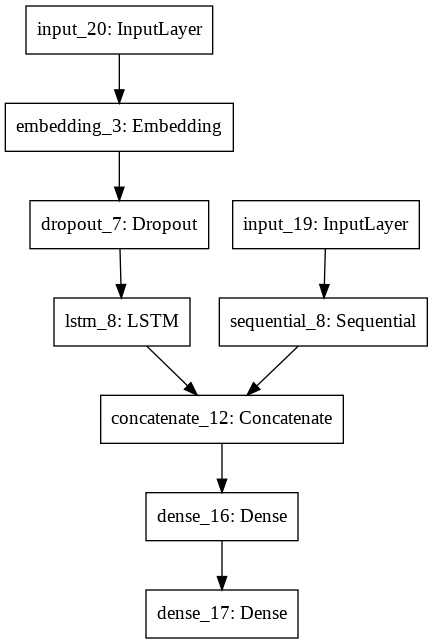

In [299]:
from tensorflow.keras.utils import plot_model
plot_model(model_glove, to_file='model0.png')

In [0]:
activations_batch, questions_batch, answers_batch, paths_batch = next(iter(train_ds))

In [0]:

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.SparseCategoricalCrossentropy(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

In [0]:

def evaluate_glove(max_steps=None):
  steps = 0
  for activation_batch, question_batch, answer_batch, path_batch in val_ds:
    if max_steps != None and steps == max_steps:
      break
    predictions = model_glove.predict(x=[activation_batch, question_batch])
    steps += 1 
    # Record metrics after each batch
    val_loss(answer_batch, predictions)
    val_accuracy(answer_batch, predictions)

In [303]:

train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []

epochs = 20 

for epoch in range(epochs):

  start = time.time()

  for activation_batch, question_batch, answer_batch, path_batch in train_ds:
    result = model_glove.train_on_batch(x=[activation_batch, question_batch], y=answer_batch)

    train_loss(result[0])
    train_accuracy(result[1])

  evaluate_glove(max_steps=100)

  template = 'Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Val Loss {:.2f}, Val Accuracy {:.2f}, Time: {:.1f} secs'
  print(template.format(epoch,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        val_loss.result(),
                        val_accuracy.result() * 100,
                        time.time() - start))
  
  train_loss_history.append(train_loss.result())
  train_acc_history.append(train_accuracy.result() * 100)
  val_loss_history.append(val_loss.result())
  val_acc_history.append(val_accuracy.result() * 100)

  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()


Epoch 0, Loss: 1.21, Accuracy: 33.31, Val Loss 1.11, Val Accuracy 32.59, Time: 6.0 secs
Epoch 1, Loss: 1.10, Accuracy: 35.15, Val Loss 1.11, Val Accuracy 33.78, Time: 3.9 secs
Epoch 2, Loss: 1.09, Accuracy: 37.39, Val Loss 1.10, Val Accuracy 33.63, Time: 4.1 secs
Epoch 3, Loss: 1.09, Accuracy: 37.40, Val Loss 1.11, Val Accuracy 33.63, Time: 4.0 secs
Epoch 4, Loss: 1.08, Accuracy: 39.52, Val Loss 1.12, Val Accuracy 30.52, Time: 4.1 secs
Epoch 5, Loss: 1.07, Accuracy: 41.92, Val Loss 1.11, Val Accuracy 33.93, Time: 3.9 secs
Epoch 6, Loss: 1.06, Accuracy: 43.81, Val Loss 1.14, Val Accuracy 32.15, Time: 4.0 secs
Epoch 7, Loss: 1.04, Accuracy: 46.60, Val Loss 1.16, Val Accuracy 32.74, Time: 4.1 secs
Epoch 8, Loss: 1.03, Accuracy: 47.23, Val Loss 1.16, Val Accuracy 34.37, Time: 4.2 secs
Epoch 9, Loss: 0.98, Accuracy: 51.86, Val Loss 1.21, Val Accuracy 31.85, Time: 4.0 secs
Epoch 10, Loss: 0.97, Accuracy: 53.31, Val Loss 1.16, Val Accuracy 36.74, Time: 4.0 secs
Epoch 11, Loss: 0.91, Accuracy:

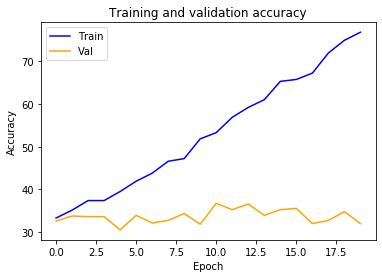

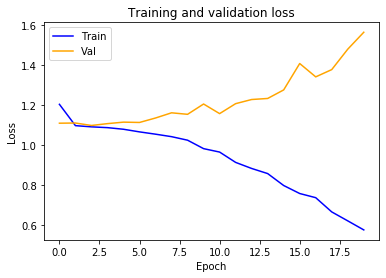

In [304]:

epochs = range(len(val_acc_history))

plt.title('Training and validation accuracy')
plt.plot(epochs, train_acc_history, color='blue', label='Train')
plt.plot(epochs, val_acc_history, color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

_ = plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, train_loss_history, color='blue', label='Train')
plt.plot(epochs, val_loss_history, color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [0]:

predictions_final=[]
def evaluate_test(max_steps=None):
  steps = 0
  for activation_batch, question_batch, answer_batch, path_batch in test_ds:
    predictions = model_glove.predict(x=[activation_batch, question_batch])
    #print(type(predictions))
    predictions_final.append(predictions)


In [0]:
evaluate_test()

In [0]:
preds=[np.argmax(y) for x in predictions_final for y in x]

In [295]:
print(classification_report(label_test,preds))

              precision    recall  f1-score   support

         0.0       0.36      0.38      0.37       224
         1.0       0.33      0.42      0.37       224
         2.0       0.38      0.27      0.32       224

    accuracy                           0.36       672
   macro avg       0.36      0.36      0.35       672
weighted avg       0.36      0.36      0.35       672



While this glove model performs equally well as compared to the one without glove embeddings (accuracy of 36%), the f-1 score for one of the classes drops below 0.33).

Anoher thing to note that is that an Image+Text model with Inception V3 activations and glove embeddings is a very heavy and complex model. By the use of glove embeddings, the total parameters in our model became twice as much as the total parameters in the Image+Text model with Inception V3 activations and a Keras Embedding layer.

Keeping all these factors in mind, we conclude that Image+Text model with Inception V3 activations and keras Embedding is the best model we could come up with. 

We couldn't achieve an accuracy greater than 36% despite trying out various models. Predicting sarcasm in text has been a diffiuclt task in the field of natural language processing. 

One reason why we think we couldn't achieve great results was the fact that memes often contain slang words and words with different spellings than the correct one ( e.g people using 'ma'/'mah' intead of my, 'lyf' instead of 'life', 'y' instead of why and so on.)

We inspected our dataset and did find a lot of such instances that according to us, deep learning models wouldn't be able to make sense of. That's our perception, but please feel free to let us know if and how we could have performed the classification task better.


Since the results of this classification didn't meet our expectations, we are performing another classification task in the next notebook where we classify memes as positive, negative or neutral.